In [ ]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)
import collections
import numpy as np
import pandas as pd
import re
import string
import scipy as sp
import gensim
import gensim.downloader as api
import nltk, nltk.data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import wordnet
from tqdm.notebook import tqdm
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from argparse import Namespace

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 640x640 with 0 Axes>

time: 139 ms (started: 2021-10-26 12:55:38 +00:00)


In [ ]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.03 s (started: 2021-10-26 12:55:39 +00:00)


# <center>Project 2 Natural Language for NLP --  Task 2 </center>

<center>   

**Name_ Student number:**
<br>
Chanxin Xie_22566456
<br>
Yiyong Duan_22628103<br>

**Date created:** Oct 5th 2022<br>
**Last modified:** Oct 25th 2022<br>


#  Task 2 Multi-class Document Classification
Using the NARRATIVE text field, predict one of the above mentioned field (NATURE_INJURY, INJ_BODY_PART, ACTIVITY, INJURY_SOURCE). 

## This notebook contains all details about Task 2: Multi-class Document Classification

**This task follows the procedures listed below:**

1. Initial Data preparation
2. Data Preprocessing
2. Split the training/testing/validation dataset
3. Perform word embedding
4. Group data into minibatch for the model via DataLoader
5. Train Model
6. Evaluation
7. Compare performance of two different models

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

%cd /content/drive/MyDrive/NLP/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NLP
time: 3.89 ms (started: 2021-10-26 12:55:42 +00:00)


In [ ]:
# Import dataset
df_org = pd.read_csv('us_data_2000.csv')
df_org.head(2)

,MINE_ID,CONTROLLER_ID,CONTROLLER_NAME,OPERATOR_ID,OPERATOR_NAME,CONTRACTOR_ID,DOCUMENT_NO,SUBUNIT_CD,SUBUNIT,ACCIDENT_DT,CAL_YR,CAL_QTR,FISCAL_YR,FISCAL_QTR,ACCIDENT_TIME,DEGREE_INJURY_CD,DEGREE_INJURY,FIPS_STATE_CD,UG_LOCATION_CD,UG_LOCATION,UG_MINING_METHOD_CD,UG_MINING_METHOD,MINING_EQUIP_CD,MINING_EQUIP,EQUIP_MFR_CD,EQUIP_MFR_NAME,EQUIP_MODEL_NO,SHIFT_BEGIN_TIME,CLASSIFICATION_CD,CLASSIFICATION,ACCIDENT_TYPE_CD,ACCIDENT_TYPE,NO_INJURIES,TOT_EXPER,MINE_EXPER,JOB_EXPER,OCCUPATION_CD,OCCUPATION,ACTIVITY_CD,ACTIVITY,INJURY_SOURCE_CD,INJURY_SOURCE,NATURE_INJURY_CD,NATURE_INJURY,INJ_BODY_PART_CD,INJ_BODY_PART,SCHEDULE_CHARGE,DAYS_RESTRICT,DAYS_LOST,TRANS_TERM,RETURN_TO_WORK_DT,IMMED_NOTIFY_CD,IMMED_NOTIFY,INVEST_BEGIN_DT,NARRATIVE,CLOSED_DOC_NO,COAL_METAL_IND
0,100003,41044,Lhoist Group,L13586,Lhoist North America,NaN,2.201210e+11,3,"STRIP, QUARY, OPEN PIT",14/03/2012,2012,1,2012,2,945,5,DAYS RESTRICTED ACTIVITY ONLY,1,?,NO VALUE FOUND,?,NO VALUE FOUND,24,"Front-end loader, Tractor-shovel, Payloader, H...",119,Not on this list,22321,600.0,12,POWERED HAULAGE,21,"CGHT I, U, B, MVNG & STTN OBJS",1,4.35,4.35,0.67,374,"Warehouseman, Bagger, Palletizer/Stacker, Stor...",28,HANDLING SUPPLIES/MATERIALS,76,SURFACE MINING MACHINES,160,"CONTUSN,BRUISE,INTAC SKIN",700,MULTIPLE PARTS (MORE THAN ONE MAJOR),0.0,8.0,0.0,N,03/26/2012,?,NO VALUE FOUND,NaN,Employee was cleaning up at the Primary Crushe...,NaN,M
1,100003,41044,Lhoist Group,L13586,Lhoist North America,NaN,2.200700e+11,30,MILL OPERATION/PREPARATION PLANT,8/01/2007,2007,1,2007,2,1105,6,"NO DYS AWY FRM WRK,NO RSTR ACT",1,?,NO VALUE FOUND,?,NO VALUE FOUND,28,Hand tools (not powered),121,Not Reported,NaN,700.0,10,HANDTOOLS (NONPOWERED),8,"STRUCK BY, NEC",1,0.02,0.02,0.02,374,"Warehouseman, Bagger, Palletizer/Stacker, Stor...",30,HAND TOOLS (NOT POWERED),46,"AXE,HAMMER,SLEDGE",180,"CUT,LACER,PUNCT-OPN WOUND",100,"HEAD,NEC",0.0,0.0,0.0,N,1/09/2007,?,NO VALUE FOUND,NaN,Handle of sledgehammer broke and head of hamme...,NaN,M


time: 129 ms (started: 2021-10-26 12:55:42 +00:00)


Functions to Preprocess the narrative text field. Same as task 1.

In [ ]:
# Clean sentences
def remove_punc(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r'[^\w\s]','',text) # remove punctuation which is connected to words
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

time: 4.7 ms (started: 2021-10-26 12:55:42 +00:00)


In [ ]:
def clean_text(sentences):
    cleaned_sentences = [] # list of sentence, with every character of sentence.
    cleaned_sen_words = [] # list of lists of sentence, with every string of words.
    for sentence in sentences:
        cleaned_sentences.append(remove_punc(sentence))
    for sentence in cleaned_sentences:
        cleaned_sen_words.append(list(filter(None, sentence.split(' ')))) # Remove empty string of list
    return cleaned_sen_words

time: 5.01 ms (started: 2021-10-26 12:55:42 +00:00)


In [ ]:
# Tokenize
from nltk.tokenize import word_tokenize
def tokenize(sentences):
    tokenized_words = []
    tokenized_sentences = []
    for sentence in sentences:
        temp_words = []
        for word in sentence:
            temp_words.append(' '.join(map(str, word_tokenize(word))))
            tokenized_words.append(' '.join(map(str, word_tokenize(word))))
        tokenized_sentences.append(temp_words)
    return tokenized_words, tokenized_sentences

time: 10.5 ms (started: 2021-10-26 12:55:42 +00:00)


In [ ]:
# Stemming
from nltk.stem import PorterStemmer

ps = PorterStemmer()
def stem(sentences):
    stem_words = []
    stem_sentences = []
    for sentence in tokenized_sentences:
        temp_words = []
        for word in sentence:
            temp_words.append(''.join(map(str,ps.stem(word))))
            stem_words.append(''.join(map(str,ps.stem(word))))
        stem_sentences.append(temp_words)
    return stem_words, stem_sentences


time: 9.21 ms (started: 2021-10-26 12:55:42 +00:00)


In [ ]:
# Lemmatize
from nltk.stem import WordNetLemmatizer
word_lem = WordNetLemmatizer()

# Fetch the pos_tag function
def fetch_pos_tag(pos_tag):
    if pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    elif pos_tag.startswith('J'):
        return wordnet.ADJ
    else:
        return None

def lemma(sentences):
    lemma_words = []
    lemma_sentences = []
    for sentence in sentences:
        tagged_sent = (nltk.pos_tag(sentence)) # [('employee','NN'),('was', 'VBD'),('foreign', 'JJ')...]
        lemma_sentence = []
        for tag in tagged_sent:
            wordnet_pos = fetch_pos_tag(tag[1]) or wordnet.NOUN # if None then regard as Noun # n,v,a,r
            lemma_words.append(word_lem.lemmatize(tag[0], pos = wordnet_pos))
            lemma_sentence.append(word_lem.lemmatize(tag[0], pos = wordnet_pos))
        lemma_sentences.append(lemma_sentence)
    return lemma_words, lemma_sentences


time: 16.8 ms (started: 2021-10-26 12:55:42 +00:00)


In [ ]:
# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
def remove_stop(sentences):
    tfidf_sentences = []
    for sentence in sentences:
        word_list = []
        for word in sentence:
            word_list.append(word)
        tfidf_sentences.append(' '.join(word_list))
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df =0, use_idf = True)
    tfidf_vectors = tfidf_vectorizer.fit_transform(tfidf_sentences)
    tfidf_array = tfidf_vectorizer.fit_transform(tfidf_sentences).toarray()
    tfidf_matrix = tfidf_vectorizer.fit_transform(tfidf_sentences).todense()
    feature_names = tfidf_vectorizer.get_feature_names()
    vector_list = []

    for matrix_index in range(len(tfidf_sentences)):
        feature_index = tfidf_matrix[matrix_index,:].nonzero()[1]
        tfidf_scores = zip([feature_names[i] for i in feature_index], [tfidf_matrix[matrix_index, x] for x in feature_index]) 
        vector_list.append(dict(tfidf_scores)) # 1989 rows dictionaries with words and vector
        
    inverse_array = tfidf_vectorizer.inverse_transform(tfidf_array)
    filtered_sentences = []
    for rows in range(len(sentences)): # 1989 rows
        filtered_sentence = []
        for word in sentences[rows]:
            if word in inverse_array[rows]:
                filtered_sentence.append(word)
        filtered_sentences.append(filtered_sentence)
    return filtered_sentences, vector_list

time: 19.8 ms (started: 2021-10-26 12:55:42 +00:00)


In [ ]:
# PRE-PROCESSING FUNCTION
def preprocessing(sentences, lemma_or_stem = 'lemma'):
    cleaned_sen_words = clean_text(sentences)
    tokenized_words, tokenized_sentences = tokenize(cleaned_sen_words)
    if lemma_or_stem == 'lemma':
        lemma_words, lemma_sentences = lemma(tokenized_sentences)
        filtered_sentences, filtered_vector = remove_stop(lemma_sentences)
    else:
        stem_words, stem_sentences = stem(tokenized_sentences)
        filtered_sentences, filtered_vector = remove_stop(stem_sentences)
    filtered_string = []
    for index in range(len(filtered_sentences)): 
        string = ''
        for word in filtered_sentences[index]:
            string = string + word + ' '
        filtered_string.append(string)
    return filtered_string, filtered_vector

time: 14 ms (started: 2021-10-26 12:55:42 +00:00)


## 1 Intial Data Cleaning
This task is to clean up the original dataset so that we can use the NARRATIVE text field to predict the degree of injury (DEGREE_INJURY). 
1. Initial cleaning up
2. Class Determination -- We make use the degree of injury code (DEGREE_INJURY_CD) to group injuries into two categories and assign the corresponding class to each row. 


### 1.1 Clean up data

As the goal is to use the NARRATIVE text field to predict the degree of injury (DEGREE_INJURY), we extract column 'DEGREE_INJURY_CD' and 'NARRATIVE' from the original dataset and remove the values in 'DEGREE_INJURY_CD' which cannot be classified.

1. We choose 'NATURE_INJURY' as the classification target.
2. It has 33 different categories include 'NO VALUE FOUND'.
3. As 'NO VALUE FOUND' contains not meaningful information which doesn't contribute to the classification, we removed all the records which correspond to 'NO VALUE FOUND'.
4. Now we have 32 categories to be classified.

In [ ]:
colunms = ['AMPUTATION OR ENUCLEATION','BURN OR SCALD (HEAT)','BURN,CHEMICL-FUME,COMPOUN','CONTUSN,BRUISE,INTAC SKIN','CRUSHING','CUT,LACER,PUNCT-OPN WOUND',
'DUST IN EYES','ELECT.ARC BURN-NOT CONTAC','FRACTURE,CHIP','HEARING LOSS OR IMPAIRMNT','HEATSTROK,SUNSTR,HT EXHAU','HERNIA;RUPTURE',
'JOINT,TENDON,MUSCL INFLAM','MULTIPLE INJURIES','OTHER INJURY,NEC','POISONING,SYSTEMIC','SCRATCH,ABRASION,SUPERFCL','SPRAIN,STRAIN RUPT DISC','UNCLASSIFIED,NOT DETERMED']

time: 3 ms (started: 2021-10-26 12:55:42 +00:00)


In [ ]:
# subset data to get column 'DEGREE_INJURY_CD','NARRATIVE'
df = df_org[['NATURE_INJURY','NARRATIVE']]
# Only keep some values in column 'NATURE_INJURY'
df = df[df["NATURE_INJURY"].isin(colunms)]

time: 9.08 ms (started: 2021-10-26 12:55:42 +00:00)


In [ ]:
df.head()

,NATURE_INJURY,NARRATIVE
0,"CONTUSN,BRUISE,INTAC SKIN",Employee was cleaning up at the Primary Crushe...
1,"CUT,LACER,PUNCT-OPN WOUND",Handle of sledgehammer broke and head of hamme...
2,"SPRAIN,STRAIN RUPT DISC",EMPLOYEE WAS CLIMBING DOWN A LADDER AND WHEN H...
3,"SPRAIN,STRAIN RUPT DISC",HE PULLED A BACK MUSCLE WHILE STACKING BAGS OF...
4,"BURN,CHEMICL-FUME,COMPOUN",EE hands began to break out in a rash after he...


time: 19.5 ms (started: 2021-10-26 12:55:42 +00:00)


### 1.2 Class Determination

#### 1.2.1 To predict 19 classes
The list below displays the percentage of each class we are going to predict.It is fairly clear that it is imbalanced. The top three classes account for almost 80% of the data: 32.4% are 'SPRAIN,STRAIN RUPT DISC ', 23.3% are 'CUT,LACER,PUNCT-OPN WOUND', 13.8% are 'FRACTURE,CHIP ' and 8% are 'CONTUSN,BRUISE,INTAC SKIN'. The remaining are fairly small.

In [ ]:
(df.NATURE_INJURY.value_counts()/len(df.NATURE_INJURY))*100

SPRAIN,STRAIN RUPT DISC      33.101045
CUT,LACER,PUNCT-OPN WOUND    23.751452
FRACTURE,CHIP                14.053426
CONTUSN,BRUISE,INTAC SKIN     8.188153
UNCLASSIFIED,NOT DETERMED     3.774681
MULTIPLE INJURIES             3.135889
JOINT,TENDON,MUSCL INFLAM     1.974448
SCRATCH,ABRASION,SUPERFCL     1.800232
BURN OR SCALD (HEAT)          1.451800
CRUSHING                      1.393728
DUST IN EYES                  1.335656
BURN,CHEMICL-FUME,COMPOUN     1.277584
HERNIA;RUPTURE                1.219512
HEARING LOSS OR IMPAIRMNT     0.754936
AMPUTATION OR ENUCLEATION     0.696864
OTHER INJURY,NEC              0.638792
POISONING,SYSTEMIC            0.580720
ELECT.ARC BURN-NOT CONTAC     0.464576
HEATSTROK,SUNSTR,HT EXHAU     0.406504
Name: NATURE_INJURY, dtype: float64

time: 9.78 ms (started: 2021-10-26 12:55:42 +00:00)


<function matplotlib.pyplot.show>

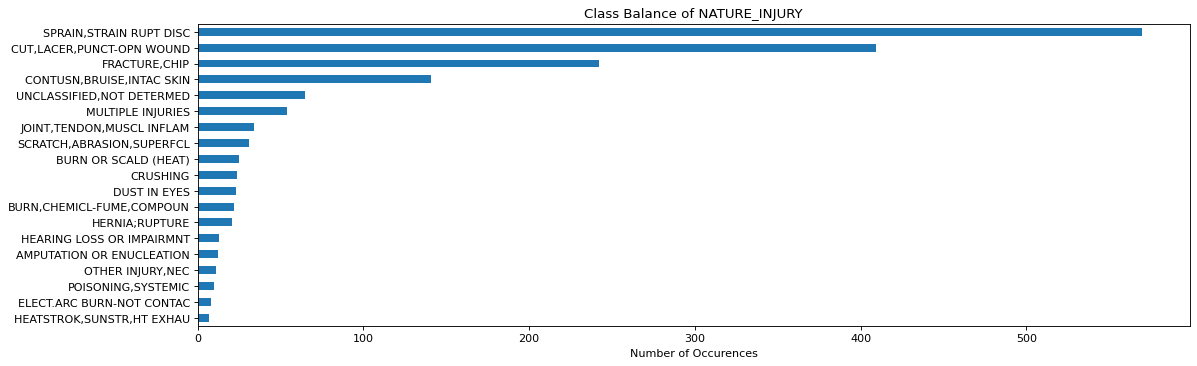

time: 370 ms (started: 2021-10-26 12:55:42 +00:00)


In [ ]:
%matplotlib inline
figure(figsize=(16, 5), dpi=80)

df_la = df.NATURE_INJURY.value_counts().sort_values()
ax = df_la.plot.barh()
ax.set_xlabel('Number of Occurences')
ax.set_title('Class Balance of NATURE_INJURY')

plt.show

#### 1.2.2 To predict 8 classes
From the graph above, we can see that the sample sizes of classes are very imbalanced, which will probably lead to low test accuracy in the training section. For comparison, we prepared one more dataset which we removed some clases with smaller sample size. 
<br>
It is fairly clear that the imbalanced-class issue has been improved. Althought the top three classes still account for almost 80% of the data. The much smaller classes are no longer in the target.

In [ ]:
threshold = 30 # Remove class frequency lower than 30
value_counts = df_org['NATURE_INJURY'].value_counts()  
to_remove = value_counts[value_counts <= threshold].index
to_remove_list = []
for i in to_remove:
    to_remove_list.append(i)

df_2 = df
df_2 = df_2[~df_2["NATURE_INJURY"].isin(to_remove_list)]
df_2 = df_2.reset_index(drop=True)
(df_2.NATURE_INJURY.value_counts()/len(df_2.NATURE_INJURY))*100

SPRAIN,STRAIN RUPT DISC      36.869340
CUT,LACER,PUNCT-OPN WOUND    26.455369
FRACTURE,CHIP                15.653299
CONTUSN,BRUISE,INTAC SKIN     9.120310
UNCLASSIFIED,NOT DETERMED     4.204398
MULTIPLE INJURIES             3.492885
JOINT,TENDON,MUSCL INFLAM     2.199224
SCRATCH,ABRASION,SUPERFCL     2.005175
Name: NATURE_INJURY, dtype: float64

time: 21.9 ms (started: 2021-10-26 12:55:43 +00:00)


<function matplotlib.pyplot.show>

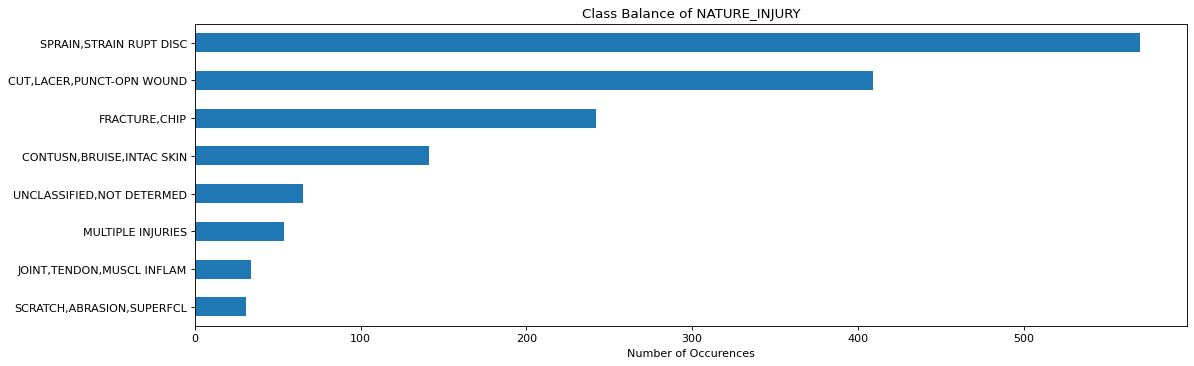

time: 286 ms (started: 2021-10-26 12:55:43 +00:00)


In [ ]:
%matplotlib inline
figure(figsize=(16, 5), dpi=80)

df_l = df_2.NATURE_INJURY.value_counts().sort_values()
ax = df_l.plot.barh()
ax.set_xlabel('Number of Occurences')
ax.set_title('Class Balance of NATURE_INJURY')

plt.show

## 2 Data Preprocessing

Tokenize, lemmatize and remove the stop words from both datasets.

In [ ]:
filtered_column, filtered_vector = preprocessing(df['NARRATIVE'],'lemma')
# within column 'narrative' is the narrative after tokenization, lemmatisation and removing stop words
df['narrative'] = filtered_column
df['filtered_NARRATIVE_vector'] = filtered_vector

time: 12.4 s (started: 2021-10-26 12:55:43 +00:00)


In [ ]:
filtered_column_2, filtered_vector_2 = preprocessing(df_2['NARRATIVE'],'lemma')
# within column 'narrative' is the narrative after tokenization, lemmatisation and removing stop words
df_2['narrative'] = filtered_column_2
df_2['filtered_NARRATIVE_vector'] = filtered_vector_2

time: 11.2 s (started: 2021-10-26 12:55:56 +00:00)


## 3 Split the training/testing/validation dataset

### 3.1 With 19 classes
1. In this section, we prepare the training, testing and validation dataset on a 70%,15%,15% proportion.
2. There are 1386 instances in training set, 306 in testing set and 297 in validation set for the dataset with 19 classes.
3. Then we assign 'train','test','val' to each row and write the split dataset back to file.

In [ ]:
df.head()

,NATURE_INJURY,NARRATIVE,narrative,filtered_NARRATIVE_vector
0,"CONTUSN,BRUISE,INTAC SKIN",Employee was cleaning up at the Primary Crushe...,employee clean primary crusher dingo skid stee...,"{'cement': 0.2155197320323387, 'clean': 0.1711..."
1,"CUT,LACER,PUNCT-OPN WOUND",Handle of sledgehammer broke and head of hamme...,handle sledgehammer broke head hammer hit empl...,"{'broke': 0.4595112972110779, 'employee': 0.12..."
2,"SPRAIN,STRAIN RUPT DISC",EMPLOYEE WAS CLIMBING DOWN A LADDER AND WHEN H...,employee climb ladder step ground slip sprain ...,"{'ankle': 0.36067143070190605, 'climb': 0.4114..."
3,"SPRAIN,STRAIN RUPT DISC",HE PULLED A BACK MUSCLE WHILE STACKING BAGS OF...,pull muscle stack bag material,"{'bag': 0.5054296286337235, 'material': 0.4174..."
4,"BURN,CHEMICL-FUME,COMPOUN",EE hands began to break out in a rash after he...,ee hand begin break rash handle material coat ...,"{'acid': 0.2624261192792845, 'begin': 0.345058..."


time: 23.6 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
args = Namespace(
    window_size=5,
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="../NLP/proj2_with_splits_task2.csv",
    seed=1337
)

time: 3.43 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
# get the needed columns for further modeling
doc = df.copy() [['NATURE_INJURY','narrative']]
doc_2 = df_2.copy() [['NATURE_INJURY','narrative']]
doc_2.head()

,NATURE_INJURY,narrative
0,"CONTUSN,BRUISE,INTAC SKIN",employee clean primary crusher dingo skid stee...
1,"CUT,LACER,PUNCT-OPN WOUND",handle sledgehammer broke head hammer hit empl...
2,"SPRAIN,STRAIN RUPT DISC",employee climb ladder step ground slip sprain ...
3,"SPRAIN,STRAIN RUPT DISC",pull muscle stack bag material
4,"SPRAIN,STRAIN RUPT DISC",ee reach air supply cutoff valve


time: 25.2 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
# Splitting train by Injury classes
# Create dict
by_injury = collections.defaultdict(list)
for _, row in doc.iterrows():
    by_injury[row.NATURE_INJURY].append(row.to_dict())

time: 238 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
# Create split data
final_list = []
np.random.seed(args.seed)
for _, item_list in sorted(by_injury.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    # Add to final list
    final_list.extend(item_list)

time: 9.13 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
# Write split data to file
final_injury = pd.DataFrame(final_list)

time: 3.75 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
# look at the number of instances for training, testing and validation set
final_injury.split.value_counts()

train    1196
test      276
val       250
Name: split, dtype: int64

time: 7.88 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
final_injury.head()

,NATURE_INJURY,narrative,split
0,AMPUTATION OR ENUCLEATION,ee believe airlock plug deenergize machine use...,train
1,AMPUTATION OR ENUCLEATION,victim stick hand confined area release chain ...,train
2,AMPUTATION OR ENUCLEATION,use drill steel raise roof pan canopy roof bol...,train
3,AMPUTATION OR ENUCLEATION,ee saw stone bandsaw rock turn draw ee right h...,train
4,AMPUTATION OR ENUCLEATION,employee instal bolt add extension steel initi...,train


time: 18.9 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
# Change col name as lab 10 to make easier
final_injury.rename(columns={'NATURE_INJURY': 'nationality', 'narrative': 'surname'}, inplace=True)

time: 3.21 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
# Write munged data to CSV
final_injury.to_csv(args.output_munged_csv, index=False)

time: 17.6 ms (started: 2021-10-26 12:56:07 +00:00)


### 3.2 With 8 classes
1. In this section, we prepare the training, testing and validation dataset on a 70%,15%,15% proportion as well.
2. There are 1078 instances in training set, 239 in testing set and 229 in validation set for the dataset with 8 classes.
3. Then we assign 'train','test','val' to each row and write the split dataset back to file.

In [ ]:
args = Namespace(
    window_size=5,
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="../NLP/proj2_with_splits_task2_2.csv",
    seed=1337
)

time: 1.41 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
# Splitting train by Injury classes
# Create dict
by_injury_2 = collections.defaultdict(list)
for _, row in doc_2.iterrows():
    by_injury_2[row.NATURE_INJURY].append(row.to_dict())

time: 226 ms (started: 2021-10-26 12:56:07 +00:00)


In [ ]:
# Create split data
final_list_2 = []
np.random.seed(args.seed)
for _, item_list in sorted(by_injury_2.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    # Add to final list
    final_list_2.extend(item_list)

time: 11.6 ms (started: 2021-10-26 12:56:08 +00:00)


In [ ]:
# Write split data to file
final_injury_2 = pd.DataFrame(final_list_2)
# look at the number of instances for training, testing and validation set
final_injury_2.split.value_counts()

train    1078
test      239
val       229
Name: split, dtype: int64

time: 12.5 ms (started: 2021-10-26 12:56:08 +00:00)


In [ ]:
final_injury_2.head()

,NATURE_INJURY,narrative,split
0,"CONTUSN,BRUISE,INTAC SKIN",operator enter loader ascend ladderfoot slip r...,train
1,"CONTUSN,BRUISE,INTAC SKIN",scaffold lug fail southeast quadrant vessel ca...,train
2,"CONTUSN,BRUISE,INTAC SKIN",ee clean pile material catwalk shovel pile col...,train
3,"CONTUSN,BRUISE,INTAC SKIN",clear feeder employee pinch right little finge...,train
4,"CONTUSN,BRUISE,INTAC SKIN",haul seal supply deck scoop strike loose coal ...,train


time: 24.4 ms (started: 2021-10-26 12:56:08 +00:00)


In [ ]:
final_injury_2.rename(columns={'NATURE_INJURY': 'nationality', 'narrative': 'surname'}, inplace=True)

time: 3 ms (started: 2021-10-26 12:56:08 +00:00)


In [ ]:
# Write munged data to CSV
final_injury_2.to_csv(args.output_munged_csv, index=False)

time: 23.1 ms (started: 2021-10-26 12:56:08 +00:00)


## 4 Vanilla RNN Layer -- Training With 19 classes dataset

In [ ]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

time: 6.65 ms (started: 2021-10-26 12:56:08 +00:00)


### 4.1 Data preparation (`Vocabulary`, `Vectorizer`, `Dataset`)



#### The `Vocabulary` Class
The first stage to map each token to a numerical version of itself. The standard methodology is to have a bijection - a mapping that can be reversed between the tokens and integers. In Python, this is simply two dictionaries.

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

time: 45.6 ms (started: 2021-10-26 12:56:08 +00:00)


In [ ]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

time: 17.3 ms (started: 2021-10-26 12:56:08 +00:00)


#### Vectorizer

The second stage of going from a text dataset to a vectorized minibatch is to iterate through the tokens of an input data point and convert each token to its integer form. The result of this iteration should be a vector. Because this vector will be combined with vectors from other data points, there is a constraint that the vectors produced by the Vectorizer should always have the same length.

In [ ]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""   
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) 
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)         
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index
        
        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nat_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])

        return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

    def to_serializable(self):
        return {'char_vocab': self.char_vocab.to_serializable(), 
                'nationality_vocab': self.nationality_vocab.to_serializable()}

time: 47.3 ms (started: 2021-10-26 12:56:08 +00:00)


#### Dataset

The final stage of the text to vectorized minibatch pipeline is to actually group the vectorized data
points.

In [ ]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df 
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
        # Class weights
        class_counts = self.train_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)

        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))
        
    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return SurnameVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]
        
        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)
        
        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector, 
                'y_target': nationality_index, 
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

time: 129 ms (started: 2021-10-26 12:56:08 +00:00)


### 4.2 Model

The `SurnameClassifier` model is composed of an Embedding layer, the ElmanRNN, and a Linear layer. The model:
1. Embeds the integers using the embedding layer. 
2. Using the RNN to compute the sequence representation vectors 
3. These summary vectors are passed through the Linear layer to compute a prediction vector

The arguments to the model: 

- the size of the embeddings - *hyperparameter*,
- the number of embeddings (i.e., vocabulary size) - determined by the data,
- the number of classes - determined by the data, and 
- the hidden state size of the RNN - *hyperparameter*.


#### (1) Retrieving the last vector of each sequence


In [ ]:
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)

time: 6.2 ms (started: 2021-10-26 12:56:08 +00:00)


#### (2)The ElmanRNN model

In [ ]:
class ElmanRNN(nn.Module):
    """ an Elman RNN built using the RNNCell """
    def __init__(self, input_size, hidden_size, batch_first=False):
        """
        Args:
            input_size (int): size of the input vectors
            hidden_size (int): size of the hidden state vectors
            bathc_first (bool): whether the 0th dimension is batch
        """
        super(ElmanRNN, self).__init__()
        
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        
        self.batch_first = batch_first
        self.hidden_size = hidden_size

    def _initial_hidden(self, batch_size):
        return torch.zeros((batch_size, self.hidden_size))

    def forward(self, x_in, initial_hidden=None):
        """The forward pass of the ElmanRNN
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                If self.batch_first: x_in.shape = (batch, seq_size, feat_size)
                Else: x_in.shape = (seq_size, batch, feat_size)
            initial_hidden (torch.Tensor): the initial hidden state for the RNN
        Returns:
            hiddens (torch.Tensor): The outputs of the RNN at each time step. 
                If self.batch_first: hiddens.shape = (batch, seq_size, hidden_size)
                Else: hiddens.shape = (seq_size, batch, hidden_size)
        """
        if self.batch_first:
            batch_size, seq_size, feat_size = x_in.size()
            x_in = x_in.permute(1, 0, 2)
        else:
            seq_size, batch_size, feat_size = x_in.size()
    
        hiddens = []

        if initial_hidden is None:
            initial_hidden = self._initial_hidden(batch_size)
            initial_hidden = initial_hidden.to(x_in.device)

        hidden_t = initial_hidden
                    
        for t in range(seq_size):
            hidden_t = self.rnn_cell(x_in[t], hidden_t)
            hiddens.append(hidden_t)
            
        hiddens = torch.stack(hiddens)

        if self.batch_first:
            hiddens = hiddens.permute(1, 0, 2)

        return hiddens



class SurnameClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes, dropout_p,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector 
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.rnn = ElmanRNN(input_size=embedding_size,
                             hidden_size=rnn_hidden_size,
                             batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)
        self._dropout_p = dropout_p
    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(F.dropout(y_out, self._dropout_p)))
        y_out = self.fc2(F.dropout(y_out, self._dropout_p))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

time: 82.8 ms (started: 2021-10-26 12:56:08 +00:00)


In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

time: 5.57 ms (started: 2021-10-26 12:56:08 +00:00)


### 4.3 Settings

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="../NLP/proj2_with_splits_task2.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",  ## ?? "model_task2.pth"
    save_dir="../NLP/",
    # Model hyper parameter
    char_embedding_size=200,
    rnn_hidden_size=128,
    # Training hyper parameter
    num_epochs=150,
    learning_rate= 0.0001,
    dropout_p = 0.0001,
    batch_size=128,
    seed=1337,
    early_stopping_criteria=5,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: True
time: 26.9 ms (started: 2021-10-26 12:56:08 +00:00)


#### Classifier

In [ ]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv, 
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               dropout_p = args.dropout_p, # Modify drop out rate by self
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

time: 239 ms (started: 2021-10-26 12:56:08 +00:00)


### 4.4 Training Routine

In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

time: 37.8 ms (started: 2021-10-26 12:56:08 +00:00)


#### Training

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/150 [00:00<?, ?it/s]

split=train:   0%|          | 0/9 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

time: 8min 45s (started: 2021-10-26 12:56:08 +00:00)


### 4.5 Compute Loss and Accuracy

In [ ]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

time: 182 ms (started: 2021-10-26 13:04:54 +00:00)


#### Results

In [ ]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.9438188076019287;
Test Accuracy: 17.578125
time: 2.86 ms (started: 2021-10-26 13:04:54 +00:00)


# Different hyperparameters and the corresponding accuracy
char_embedding_size:100, RNN hidden size: 64, lr: 0.001, dr: 0.001, test loss: 2.94, test accuracy: 6.64;

char_embedding_size:100, RNN hidden size: 128, lr: 0.0001, dr: 0.0001, test loss: 2.94, test accuracy: 12.5;

char_embedding_size:100, RNN hidden size: 192, lr: 0.0001, dr: 0.0001, test loss: 2.94, test accuracy: 10.94;

char_embedding_size:200, RNN hidden size: 128, lr: 0.0001, dr: 0.0001, test loss: 2.94, test accuracy: 17.58;

char_embedding_size:512, RNN hidden size: 128, lr: 0.001, dr: 0.001, test loss: 2.93, test accuracy: 7.81;

char_embedding_size:256, RNN hidden size: 128, lr: 0.001, dr: 0.001, test loss: 2.94, test accuracy: 12.5;


After tunning parameters like char_embedding_size, RNN hidden size, learning rate and dropping rate, we have a justifiable result with 17.58% test accuracy, though the accuracy is pretty low. We consider the imbalanced classes lead to this result, so we decide to use another dataset with removing low frequent classes to train this model and check the accuracy again.

### 4.6 Training With 8 classes dataset

#### Settings

In [ ]:
args = Namespace(
    # Data and path information
    surname_csv="../NLP/proj2_with_splits_task2_2.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",  ## ?? "model_task2.pth"
    save_dir="../NLP/",
    # Model hyper parameter
    char_embedding_size=200,
    rnn_hidden_size=128,
    # Training hyper parameter
    num_epochs=150,
    learning_rate= 0.0001,
    dropout_p = 0.0001,
    batch_size=128,
    seed=1337,
    early_stopping_criteria=5,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Using CUDA: True
time: 30.8 ms (started: 2021-10-26 13:04:55 +00:00)


#### Classifier

In [ ]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv, 
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(embedding_size=args.char_embedding_size, 
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               dropout_p = args.dropout_p, # Modify drop out rate by self
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

time: 218 ms (started: 2021-10-26 13:04:55 +00:00)


In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}


def update_train_state(args, model, train_state):
    """Handle the training state updates.

    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

time: 38.3 ms (started: 2021-10-26 13:04:55 +00:00)


####  Training

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
    
loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
    
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = classifier(x_in=batch_dict['x_data'], 
                                x_lengths=batch_dict['x_length'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break
            
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/150 [00:00<?, ?it/s]

split=train:   0%|          | 0/8 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

time: 7min 49s (started: 2021-10-26 13:04:55 +00:00)


####  Compute Loss and Accuracy

In [ ]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))

classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)
loss_func = nn.CrossEntropyLoss(dataset.class_weights)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(batch_dict['x_data'],
                         x_lengths=batch_dict['x_length'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

time: 105 ms (started: 2021-10-26 13:12:44 +00:00)


In [ ]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.0866777896881104;
Test Accuracy: 16.40625
time: 2.34 ms (started: 2021-10-26 10:31:37 +00:00)


## 5 GRU

We use conditioned model with observing the `NATURE_INJURY` before generating a `NARRATIVE` sentence.

In [ ]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torch.nn.utils import rnn as rnn_utils

time: 5 ms (started: 2021-10-26 10:31:37 +00:00)


### 5.1 Data preparation (`Vocabulary` `Sequence` `Vectorizer` `Dataset`)


#### `Vocabulary`

In [ ]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary
        
        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

time: 37.2 ms (started: 2021-10-26 12:52:54 +00:00)


In [ ]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

time: 26.5 ms (started: 2021-10-26 12:52:57 +00:00)


#### Vectorizer

In [ ]:
class InjuryVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""    
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps words to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """Vectorize a surname into a vector of observations and targets
        
        The outputs are the vectorized surname split into two vectors:
            surname[:-1] and surname[1:]
        At each timestep, the first vector is the observation and the second vector is the target. 
        
        Args:
            surname (str): the surname to be vectorized
            vector_length (int): an argument for forcing the length of index vector
        Returns:
            a tuple: (from_vector, to_vector)
            from_vector (numpy.ndarray): the observation vector 
            to_vector (numpy.ndarray): the target prediction vector
        """
        indices = [self.char_vocab.begin_seq_index] 
        indices.extend(self.char_vocab.lookup_token(token) for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices) - 1

        from_vector = np.empty(vector_length, dtype=np.int64)         
        from_indices = indices[:-1]
        from_vector[:len(from_indices)] = from_indices
        from_vector[len(from_indices):] = self.char_vocab.mask_index

        to_vector = np.empty(vector_length, dtype=np.int64)
        to_indices = indices[1:]
        to_vector[:len(to_indices)] = to_indices
        to_vector[len(to_indices):] = self.char_vocab.mask_index
        
        return from_vector, to_vector

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surname dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Instantiate the vectorizer from saved contents
        
        Args:
            contents (dict): a dict holding two vocabularies for this vectorizer
                This dictionary is created using `vectorizer.to_serializable()`
        Returns:
            an instance of SurnameVectorizer
        """
        char_vocab = SequenceVocabulary.from_serializable(contents['char_vocab'])
        nat_vocab =  Vocabulary.from_serializable(contents['nationality_vocab'])

        return cls(char_vocab=char_vocab, nationality_vocab=nat_vocab)

    def to_serializable(self):
        """ Returns the serializable contents """
        return {'char_vocab': self.char_vocab.to_serializable(), 
                'nationality_vocab': self.nationality_vocab.to_serializable()}

time: 52.9 ms (started: 2021-10-26 12:53:00 +00:00)


#### Dataset

In [ ]:
class NarDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df 
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size), 
                             'val': (self.val_df, self.validation_size), 
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')
        
    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        
        surname_df = pd.read_csv(surname_csv)
        return cls(surname_df, InjuryVectorizer.from_dataframe(surname_df))
        
    @classmethod
    def load_dataset_and_load_vectorizer(cls, surname_csv, vectorizer_filepath):
        """Load dataset and the corresponding vectorizer. 
        Used in the case in the vectorizer has been cached for re-use
        
        Args:
            surname_csv (str): location of the dataset
            vectorizer_filepath (str): location of the saved vectorizer
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(surname_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """a static method for loading the vectorizer from file
        
        Args:
            vectorizer_filepath (str): the location of the serialized vectorizer
        Returns:
            an instance of SurnameVectorizer
        """
        with open(vectorizer_filepath) as fp:
            return InjuryVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """saves the vectorizer to disk using json
        
        Args:
            vectorizer_filepath (str): the location to save the vectorizer
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point: (x_data, y_target, class_index)
        """
        row = self._target_df.iloc[index]
        
        from_vector, to_vector = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)
        
        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': from_vector, 
                'y_target': to_vector, 
                'class_index': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

time: 92 ms (started: 2021-10-26 12:53:07 +00:00)


### 5.2 GRU Model

In [ ]:
class InjuryGenerationModel(nn.Module):
    def __init__(self, char_embedding_size, char_vocab_size, num_nationalities, dropout_p,
                 rnn_hidden_size, pretrained_embeddings=None, batch_first=True, padding_idx=0 ):
        """
        Args:
            char_embedding_size (int): The size of the character embeddings
            char_vocab_size (int): The number of characters to embed
            num_nationalities (int): The size of the prediction vector 
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will 
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding; 
                see torch.nn.Embedding
            dropout_p (float): the probability of zeroing activations using
                the dropout method.  higher means more likely to zero.
            pretrained_embeddings: The pretrained embedding with Glove corpus
        """
        super(InjuryGenerationModel, self).__init__()

        # Use Glove for pretrained embeddings while True
        # Only for char embedding in Classifation
        if pretrained_embeddings is None:
            self.char_emb = nn.Embedding(num_embeddings=char_vocab_size,
                                        embedding_dim=char_embedding_size,
                                        padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.char_emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)

        self.nation_emb = nn.Embedding(num_embeddings=num_nationalities,
                                       embedding_dim=rnn_hidden_size)

        self.rnn = nn.GRU(input_size=char_embedding_size, 
                          hidden_size=rnn_hidden_size,
                          batch_first=batch_first)
        
        self.fc = nn.Linear(in_features=rnn_hidden_size, 
                            out_features=char_vocab_size)
        
        self._dropout_p = dropout_p

    def forward(self, x_in, nationality_index, apply_softmax=False):
        """The forward pass of the model
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, max_seq_size)
            nationality_index (torch.Tensor): The index of the nationality for each data point
                Used to initialize the hidden state of the RNN
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, char_vocab_size)
        """
        x_embedded = self.char_emb(x_in)
        
        # hidden_size: (num_layers * num_directions, batch_size, rnn_hidden_size)
        # L,N,F
        nationality_embedded = self.nation_emb(nationality_index).unsqueeze(0)

        y_out, _ = self.rnn(x_embedded, nationality_embedded)

        # N,L,F
        batch_size, seq_size, feat_size = y_out.shape
        y_out = y_out.contiguous().view(batch_size * seq_size, feat_size)

        y_out = self.fc(F.dropout(y_out, p=self._dropout_p))
                         
        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        new_feat_size = y_out.shape[-1]
        y_out = y_out.view(batch_size, seq_size, new_feat_size)
            
        return y_out

time: 44.3 ms (started: 2021-10-26 12:53:11 +00:00)


#### Sample from model

In [ ]:
def sample_from_model(model, vectorizer, nationalities, sample_size=20, 
                      temperature=1.0):
    """Sample a sequence of indices from the model
    
    Args:
        model (SurnameGenerationModel): the trained model
        vectorizer (SurnameVectorizer): the corresponding vectorizer
        nationalities (list): a list of integers representing nationalities
        sample_size (int): the max length of the samples
        temperature (float): accentuates or flattens 
            the distribution. 
            0.0 < temperature < 1.0 will make it peakier. 
            temperature > 1.0 will make it more uniform
    Returns:
        indices (torch.Tensor): the matrix of indices; 
        shape = (num_samples, sample_size)
    """
    num_samples = len(nationalities)
    begin_seq_index = [vectorizer.char_vocab.begin_seq_index 
                       for _ in range(num_samples)]
    begin_seq_index = torch.tensor(begin_seq_index, 
                                   dtype=torch.int64).unsqueeze(dim=1)
    indices = [begin_seq_index]
    nationality_indices = torch.tensor(nationalities, dtype=torch.int64).unsqueeze(dim=0)
    h_t = model.nation_emb(nationality_indices)
    
    for time_step in range(sample_size):
        x_t = indices[time_step]
        x_emb_t = model.char_emb(x_t)
        rnn_out_t, h_t = model.rnn(x_emb_t, h_t)
        prediction_vector = model.fc(rnn_out_t.squeeze(dim=1))
        probability_vector = F.softmax(prediction_vector / temperature, dim=1)
        indices.append(torch.multinomial(probability_vector, num_samples=1))
    indices = torch.stack(indices).squeeze().permute(1, 0)
    return indices

time: 14.7 ms (started: 2021-10-26 12:53:15 +00:00)


#### Decode samples

In [ ]:
def decode_samples(sampled_indices, vectorizer):
    """Transform indices into the string form of a surname
    
    Args:
        sampled_indices (torch.Tensor): the inidces from `sample_from_model`
        vectorizer (SurnameVectorizer): the corresponding vectorizer
    """
    decoded_surnames = []
    vocab = vectorizer.char_vocab
    
    for sample_index in range(sampled_indices.shape[0]):
        surname = ""
        for time_step in range(sampled_indices.shape[1]):
            sample_item = sampled_indices[sample_index, time_step].item()
            if sample_item == vocab.begin_seq_index:
                continue
            elif sample_item == vocab.end_seq_index:
                break
            else:
                surname += vocab.lookup_index(sample_item)
        decoded_surnames.append(surname)
    return decoded_surnames
            

time: 9.01 ms (started: 2021-10-26 12:53:19 +00:00)


### 5.3 Training Routine

#### 5.3.1 Helper functions

In [ ]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """Handle the training state updates.
    Components:
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    :param args: main arguments
    :param model: model to train
    :param train_state: a dictionary representing the training state values
    :returns:
        a new train_state
    """

    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # If loss worsened
        if loss_t >= loss_tm1:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    """Normalize tensor sizes
    
    Args:
        y_pred (torch.Tensor): the output of the model
            If a 3-dimensional tensor, reshapes to a matrix
        y_true (torch.Tensor): the target predictions
            If a matrix, reshapes to be a vector
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

time: 53.7 ms (started: 2021-10-26 12:53:22 +00:00)


#### 5.3.2 General utilities

In [ ]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def load_glove_from_file(glove_filepath):
    """
    Load the GloVe embeddings 
    
    Args:
        glove_filepath (str): path to the glove embeddings file 
    Returns:
        word_to_index (dict), embeddings (numpy.ndarary)
    """

    word_to_index = {}
    embeddings = []
    with open(glove_filepath, encoding="utf8") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ") # each line: word num1 num2 ...
            word_to_index[line[0]] = index # word = line[0] 
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)

def make_embedding_matrix(glove_filepath, words):
    """
    Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddigns
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove_from_file(glove_filepath)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

time: 26.5 ms (started: 2021-10-26 12:53:26 +00:00)


#### 5.3.3 Settings and some prep work 

In [ ]:
args = Namespace(
    # Data and Path information
    Nar_csv="../NLP/proj2_with_splits_task2.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/model1_unconditioned_surname_generation",
    # Model hyper parameters
    glove_filepath = "../NLP/glove.6B.100d.txt", # Use Glove.6B.100d for embedding corpus, available from https://nlp.stanford.edu/data/glove.6B.zip
    use_glove = True,
    char_embedding_size=512, # if use glove, the char_embedding_size is the same as glove
    rnn_hidden_size=256, # parameter worth tuning
    # Training hyper parameters
    seed=1337,
    learning_rate=0.01, # parameter worth tuning
    dropout_p = 0.01, # parameter worth tuning
    batch_size=128,
    num_epochs=150,
    early_stopping_criteria=10,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/model1_unconditioned_surname_generation/vectorizer.json
	model_storage/model1_unconditioned_surname_generation/model.pth
Using CUDA: True
time: 32.3 ms (started: 2021-10-26 12:53:29 +00:00)


#### 5.3.4 Initializations

In [ ]:
# Use Glove for embeddings
args.use_glove = True

if args.reload_from_files:
    # training from a checkpoint
    dataset = NarDataset.load_dataset_and_load_vectorizer(args.Nar_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = NarDataset.load_dataset_and_make_vectorizer(args.Nar_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()
# Use GloVe or randomly initialized embeddings

if args.use_glove:
    words = vectorizer.char_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

Using pre-trained embeddings
time: 15.7 s (started: 2021-10-26 12:53:35 +00:00)


In [ ]:
model = InjuryGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               num_nationalities=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index,
                               dropout_p=args.dropout_p)

time: 14.2 ms (started: 2021-10-26 12:53:55 +00:00)


### 5.4 Training Loop

In [ ]:
from datetime import datetime
start=datetime.now()

mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'], 
                           nationality_index=batch_dict['class_index'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'], 
                           nationality_index=batch_dict['class_index'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
            
        # move model to cpu for sampling
        
        nationalities = np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, nationalities=nationalities), 
            vectorizer)
        
        sample1 = "{}->{}".format(vectorizer.nationality_vocab.lookup_index(nationalities[0]), 
                                  sampled_surnames[0])
        sample2 = "{}->{}".format(vectorizer.nationality_vocab.lookup_index(nationalities[1]), 
                                  sampled_surnames[1])
        epoch_bar.set_postfix(sample1=sample1, 
                              sample2=sample2)
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

except KeyboardInterrupt:
    print("Exiting loop")
# Print the model execution time
print("time consumes:",datetime.now()-start)

training routine:   0%|          | 0/150 [00:00<?, ?it/s]

split=train:   0%|          | 0/9 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

time consumes: 0:04:03.481776
time: 4min 3s (started: 2021-10-26 10:31:59 +00:00)


### 5.5 Inference and Sampling

In [ ]:
# compute the loss & accuracy on the test set using the best available model

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'], 
                   nationality_index=batch_dict['class_index'])

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
    
    # compute the running loss and running accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

time: 175 ms (started: 2021-10-26 10:36:02 +00:00)


#### Results

In [ ]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.249753177165985;
Test Accuracy: 62.3126171943954
time: 2.27 ms (started: 2021-10-26 10:36:02 +00:00)


# Different hyperparameters and the corresponding accuracy

learning_rate=0.0001, dropout_p = 0.0001, char_embedding_size=32, rnn_hidden_size=32,  Test loss: 2.84%, Test Accuracy: 19.85%;

learning_rate=0.0001, dropout_p = 0.0001, char_embedding_size=128, rnn_hidden_size=128,  Test loss: 2.06%, Test Accuracy: 38.90%;

learning_rate=0.0001, dropout_p = 0.0001, char_embedding_size=256, rnn_hidden_size=128,  Test loss: 2.02%, Test Accuracy: 40.88%;

learning_rate=0.0001, dropout_p = 0.0001, char_embedding_size=256, rnn_hidden_size=256,  Test loss: 1.89%, Test Accuracy: 43.36%;

learning_rate=0.0001, dropout_p = 0.0001, char_embedding_size=512, rnn_hidden_size=256,  Test loss: 1.85%, Test Accuracy: 44.16%;

learning_rate=0.001, dropout_p = 0.001, char_embedding_size=512, rnn_hidden_size=256,  Test loss: 1.26%, Test Accuracy: 61.49%;

learning_rate=0.01, dropout_p = 0.01, char_embedding_size=512, rnn_hidden_size=256,  Test loss: 1.24%, Test Accuracy: 62.31%;


The above result shows that learning rate, dropout rate, embedding size and rnn hidden size have influences on the test accuracy. 

#### Sampling

In [ ]:
model = model.cpu()
for index in range(len(vectorizer.nationality_vocab)):
    nationality = vectorizer.nationality_vocab.lookup_index(index)
    print("Sampled for {}: ".format(nationality))
    sampled_indices = sample_from_model(model, vectorizer,  
                                        nationalities=[index] * 3, 
                                        temperature=0.7)
    for sampled_surname in decode_samples(sampled_indices, vectorizer):
        print("-  " + sampled_surname)

Sampled for AMPUTATION OR ENUCLEATION: 
-  worker contact emplo
-  ee ee cover cause la
-  ee work accident tru
Sampled for BURN OR SCALD (HEAT): 
-  employee walk cire s
-  employee attempt spr
-  une loader raise con
Sampled for BURN,CHEMICL-FUME,COMPOUN: 
-  ee material maintena
-  place injury hole ba
-  employee step bolt s
Sampled for CONTUSN,BRUISE,INTAC SKIN: 
-  ee allege employee c
-  employee change begi
-  ee slip company corn
Sampled for CRUSHING: 
-  employee door stitch
-  employee work air we
-  employee dust block 
Sampled for CUT,LACER,PUNCT-OPN WOUND: 
-  employee climb 
-  employee allege bar 
-  employee couple fork
Sampled for DUST IN EYES: 
-  injure ee loader sta
-  drive leave try push
-  injure walk complain
Sampled for ELECT.ARC BURN-NOT CONTAC: 
-  employee walk contro
-  ee rock strike left 
-  hold bad employee st
Sampled for FRACTURE,CHIP: 
-  employee hit hand pi
-  ee state load truck 
-  loose roof bolt pick
Sampled for HEARING LOSS OR IMPAIRMNT: 
-  r

### 5.6 Training with 8 Classes dataset

#### 5.6.1 Settings

In [ ]:
args = Namespace(
    # Data and Path information
    Nar_csv="../NLP/proj2_with_splits_task2_2.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir="model_storage/model1_unconditioned_surname_generation",
    glove_filepath = "../NLP/glove.6B.100d.txt", # Use Glove.6B.100d for embedding corpus, available from https://nlp.stanford.edu/data/glove.6B.zip
    use_glove = True,
    # Model hyper parameters
    char_embedding_size=512,
    rnn_hidden_size=256,
    # Training hyper parameters
    seed=1337,
    learning_rate=0.01,
    dropout_p = 0.01,
    batch_size=128,
    num_epochs=150,
    early_stopping_criteria=10,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/model1_unconditioned_surname_generation/vectorizer.json
	model_storage/model1_unconditioned_surname_generation/model.pth
Using CUDA: True
time: 26 ms (started: 2021-10-26 10:36:03 +00:00)


#### 5.6.2 Initialization

In [ ]:
# Use Glove for embeddings
args.use_glove = True

if args.reload_from_files:
    # training from a checkpoint
    dataset = NarDataset.load_dataset_and_load_vectorizer(args.Nar_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = NarDataset.load_dataset_and_make_vectorizer(args.Nar_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()
# Use GloVe or randomly initialized embeddings

if args.use_glove:
    words = vectorizer.char_vocab._token_to_idx.keys()
    embeddings = make_embedding_matrix(glove_filepath=args.glove_filepath, 
                                       words=words)
    print("Using pre-trained embeddings")
else:
    print("Not using pre-trained embeddings")
    embeddings = None

time: 298 ms (started: 2021-10-26 10:36:03 +00:00)


#### 5.6.3 Training

In [ ]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'], 
                           nationality_index=batch_dict['class_index'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'], 
                           nationality_index=batch_dict['class_index'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
            
        # move model to cpu for sampling
        
        nationalities = np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, nationalities=nationalities), 
            vectorizer)
        
        sample1 = "{}->{}".format(vectorizer.nationality_vocab.lookup_index(nationalities[0]), 
                                  sampled_surnames[0])
        sample2 = "{}->{}".format(vectorizer.nationality_vocab.lookup_index(nationalities[1]), 
                                  sampled_surnames[1])
        epoch_bar.set_postfix(sample1=sample1, 
                              sample2=sample2)
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

training routine:   0%|          | 0/150 [00:00<?, ?it/s]

split=train:   0%|          | 0/8 [00:00<?, ?it/s]

split=val:   0%|          | 0/1 [00:00<?, ?it/s]

time: 3min 37s (started: 2021-10-26 10:36:03 +00:00)


###### 5.6.4 Compute Accuracy and Loss

In [ ]:
# compute the loss & accuracy on the test set using the best available model

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'], 
                   nationality_index=batch_dict['class_index'])

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)
    
    # compute the running loss and running accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

time: 105 ms (started: 2021-10-26 10:39:40 +00:00)


##### Results

In [ ]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 1.2173353433609009;
Test Accuracy: 63.482814574421006
time: 3.27 ms (started: 2021-10-26 10:39:40 +00:00)


#### 5.6.5 Sampling

In [ ]:
model = model.cpu()
for index in range(len(vectorizer.nationality_vocab)):
    nationality = vectorizer.nationality_vocab.lookup_index(index)
    print("Sampled for {}: ".format(nationality))
    sampled_indices = sample_from_model(model, vectorizer,  
                                        nationalities=[index] * 3, 
                                        temperature=0.7)
    for sampled_surname in decode_samples(sampled_indices, vectorizer):
        print("-  " + sampled_surname)

Sampled for CONTUSN,BRUISE,INTAC SKIN: 
-  perform pinch employ
-  employee state piece
-  miner come fell thum
Sampled for CUT,LACER,PUNCT-OPN WOUND: 
-  employee pull materi
-  employee instal face
-  employee remove caus
Sampled for FRACTURE,CHIP: 
-  employee slip instil
-  ee lift cause finger
-  employee walk contin
Sampled for JOINT,TENDON,MUSCL INFLAM: 
-  employee apply ee sh
-  ee state sper stitch
-  cut time release sur
Sampled for MULTIPLE INJURIES: 
-  ee weed catch leave 
-  employee state hand 
-  assist stand remove 
Sampled for SCRATCH,ABRASION,SUPERFCL: 
-  vee come remove scre
-  ee state piece stick
-  employee cause line 
Sampled for SPRAIN,STRAIN RUPT DISC: 
-  employee loader load
-  employee walk step d
-  employee state state
Sampled for UNCLASSIFIED,NOT DETERMED: 
-  employee work truck 
-  employee ankle fract
-  ee use press felt pa
time: 160 ms (started: 2021-10-26 10:39:40 +00:00)


### 5.7 GRU Performance Conclusion
8 classes vs 19 classes
1. The test accuracy between Imbalanced and balanced dataset is not obviously different (62.18% vs 63.48%), which indicates that GRU model is compatible with imbalanced dataset.
GRU vs RNN
2. Compared to RNN model, the GRU model's test accuracy is significantly better, as well as the compatibility with imbalanced dataset. 

## 6 Model Comparison

The table below display the training time, test loss and accuracy for predicting 19 classes and 8 classes with RNN and GRU respectively.
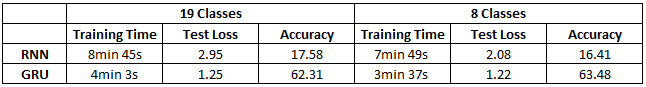


### 6.1 Training Time
* For RNN, the training time for both more and less classes are over 8 minutes.
* By comparasion, it takes a lot less time to train using GRU, average less than 4 minues.
<br>
<br>
From the perspective of training time, GRU is faster than RNN.

### 6.2 Test Loss
* The test loss for RNN is 2.95 and 2.08 for more and less classes respectively.
* The test loss for GRU is 1.25 and 1.22 for more and less classes respectively.
<br>
<br>
As mentioned in task 1, the objective of the learning model is to minimize the value of loss function, a lower loss is desirable as it indicates a better model. 
<br>
When comparing dataset with more and less classes, model trained on less classes have slightly small loss, both RNN and GRU acts the same. Although the difference is very subtle.
<br>
When comparing RNN and GRU, the loss calulated via GRU is about half of which calulated via RNN, which indicates that GRU is a better model.

### 6.3 Accuracy
* The test loss for RNN is 17.58 and 16.41 for more and less classes respectively.
* The test loss for GRU is 62.31 and 63.48 for more and less classes respectively.
<br>
<br>
After the weights and parameters are learned (trained), we use the trained model to conduct the classification and use accuracy to represent the percentage of misclassification.
<br>
When comparing dataset with more and less classes, no matter for RNN or GRU, the accuracy differences are very subtle. It seems the number of classes or the proportion of different classes won't effect the accuracy with RNN or GRU.
<br>
On the other hand, the accuracy improved dramatically when using GRU, it indicates GRU is a much better model in this case.

### 6.4 Conclusion
From the analysis above, we can see that no matter it's training time, GRU with GloVe as word embedding method performs much better than RNN with one-hot-encoder embedding.
<br>
It is intuitive:
1. GloVe is considered a better word embedding method than one-hot-encoding.
It is a pre-trained embedding mothed which performed on an aggregated global word-word co-occurrence matrix. It captures both global statistics and local statistics of a corpus.
2. Both RNN and GRU use the previous data points in the sequence to produce the current output. Which enable them to take care of the order of the data points and capture the underlying structure of the sequential data. 
3. GRU has the same workflow as RNN. However, inside a GRU cell, it has update gate(update with the candidate state or not) and reset gate (decide previous cell state is important or not), which helps control the flow of information and prevent the vanishing gradient problem which RNN has.

In this case, it is clear that GRU with GloVe as word embedding method performs much better.